# Initialization

## Importing libs and setting plot style

In [1]:
import itertools
import multiprocessing as mp
import os
import random
import threading
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from atpbar import atpbar, flush
from matplotlib import rc

In [2]:
# Setting plot style

sns.set()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.0})

rc("text", usetex=True)

sns.set_style("ticks")
sns.set_style(
    "whitegrid",
    {
        "axes.edgecolor": "black",
        "axes.grid": True,
        "axes.axisbelow": True,
        "axes.labelcolor": ".15",
        "grid.color": "0.9",
        "grid.linestyle": "-",
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.bottom": True,
        "xtick.top": True,
        "ytick.left": True,
        "ytick.right": True,
        "font.family": ["sans-serif"],
        "font.sans-serif": ["Liberation Sans", "Bitstream Vera Sans", "sans-serif"],
    },
)

## Global variables

In [3]:
# folder with stored data
data_folder = "../data_folder"

# MH parameters
spins = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
sigmas = [0.4, 0.35, 0.35, 0.35, 0.35, 0.35, 0.32, 0.3]
lengths = [1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000, 1000000]
burnins = [10, 10, 10, 10, 10, 10, 10, 10]
chains = [30, 30, 30, 30, 30, 30, 30, 30]

# set optimal number of threads
optimal_number_of_threads = int(mp.cpu_count())
print(f"optimal number of threads: {optimal_number_of_threads}")

optimal number of threads: 12


# Angles 

## Computation

In [4]:
# takes an intertwiner and returns the corresponding angle eigenvalue
def from_intertwiner_to_angle(matrix_element, spin):
    return (matrix_element * (matrix_element + 1) - 2 * spin * (spin + 1)) / (
        2 * spin * (spin + 1)
    )

In [5]:
def from_draws_to_angles(
    folder_prefix,
    spin,
    length,
    burnin,
    angle_path,
    chain_id,
    n,
    name,
    lag_max_autocorr=8000,
    node_autocorr=1,
):

    for i in atpbar(range(n), name=name):
        time.sleep(0.0001)

    draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"

    # load in memory the stored draws
    df = pd.read_csv(draw_path, low_memory=False)
    df.columns = df.columns.str.replace("intertwiner ", "node ", regex=True)
    df.columns = df.columns.str.replace("multeplicity", "multiplicity", regex=True)

    # retrieving relevant parameters
    multiplicity = df[["draw multiplicity"]].to_numpy().astype(int)
    total_accept_draws = int(df["total accept. draws"][0])
    total_accept_rate = float(df["total accept. rate"][0].strip("%"))
    total_run_time = float(df["total run time"][0].strip(" s"))

    # dropping columns (leaving multiplicity)
    df = df.drop(
        columns=[
            "draw amplitude",
            "total accept. draws",
            "total accept. rate",
            "total run time",
        ]
    )

    # from intertwiners to angles
    df.iloc[:, :16] = df.iloc[:, :16].apply(from_intertwiner_to_angle, args=(spin,))

    # taking multiplicity into account
    df = df.loc[df.index.repeat(df["draw multiplicity"])]

    # dropping multiplicity column
    df = df.drop(
        columns=[
            "draw multiplicity",
        ]
    )

    # remove some more iterations as burn-in phase
    # (I do this as I think b = 10 is too low)
    # additional_burnin = int(490)
    # df.drop(index=df.index[:additional_burnin], axis=0, inplace=True)

    ##########################################################
    # Computing autocorrelation (acf)
    ##########################################################

    acf_node = sm.tsa.acf(df[f"node {node_autocorr}"], nlags=lag_max_autocorr)
    df_final = pd.DataFrame(acf_node, columns=[f"node {node_autocorr}"])
    df_final.index.names = ["lag"]

    angle_autocorr_path_chain = (
        f"{angle_path}/autocorrelations/node_{node_autocorr}_chain_{chain_id}.csv"
    )
    df_final.to_csv(angle_autocorr_path_chain, index=True)

    ##########################################################
    # Computing exp values (avg) and quantum spread (std dev)
    ##########################################################

    df_final = pd.concat([df.mean(), df.std()], axis=1)
    df_final.columns = ["cosine angle avg", "cosine angle std"]

    angle_exp_values_path_chain = f"{angle_path}/exp_values/chain_{chain_id}.csv"
    df_final.to_csv(angle_exp_values_path_chain, index=True)

    ##########################################################
    # Computing correlations (pearson corr)
    ##########################################################

    df_final = df.corr(method="pearson")

    angle_corr_path_chain = f"{angle_path}/correlations/chain_{chain_id}.csv"
    df_final.to_csv(angle_corr_path_chain, index=True)

In [6]:
# Converts multiple draws into angles exp. values, quantum spread, correlations and autocorrelations.
# Store the result for each chain, then combines all chains in another CSV file
def angles_compute(
    data_folder,
    spin,
    length,
    sigma,
    burnin,
    number_of_chains,
    number_of_threads=optimal_number_of_threads,
    node_autocorr=1,
):

    folder_prefix = f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}"
    chain_id_collection = []

    # if number_of_chains > number_of_threads:
    #    print(
    #        "Warning: you are using more chains than available threads, performance will be affected\n"
    #    )

    for chain_id in range(1, number_of_chains + 1):
        draw_path = f"{folder_prefix}/draws/draws_chain_{chain_id}.csv"
        if os.path.isfile(draw_path):
            chain_id_collection.append(chain_id)
        else:
            warnings.warn("Warning: the draw %s was not found" % (draw_path))

    chains_to_assemble = len(chain_id_collection)

    if chains_to_assemble != 0:

        angle_path = f"{folder_prefix}/operators/angles"

        angle_path_exp_values = f"{angle_path}/exp_values"
        angle_path_correlations = f"{angle_path}/correlations"
        angle_path_autocorrelations = f"{angle_path}/autocorrelations"

        os.makedirs(f"{angle_path_exp_values}", exist_ok=True)
        os.makedirs(f"{angle_path_correlations}", exist_ok=True)
        os.makedirs(f"{angle_path_autocorrelations}", exist_ok=True)

        print(
            f"\nComputing exp. values, quantum spread, correlations and autocorrelations of {chains_to_assemble} draws, using {number_of_threads} threads...\n"
        )

        print(
            f"\nspin = {spin}, length = {length}, sigma = {sigma}, length = {length}, burnin = {burnin}, node_autocorr = {node_autocorr}\n"
        )

        threads = []
        for chain_id in chain_id_collection:

            name = "chain {}".format(chain_id)
            n = random.randint(number_of_threads, 10000)

            t = threading.Thread(
                target=from_draws_to_angles,
                args=(
                    folder_prefix,
                    spin,
                    length,
                    burnin,
                    angle_path,
                    chain_id,
                    n,
                    name,
                ),
            )
            threads.append(t)
            t.start()

        # wait for the threads to complete
        for t in threads:
            t.join()

        flush()

        print(f"All draws have been processed")

        print(f"\nAssembling {chains_to_assemble} chains...")

        ##########################################################
        # Assembling autocorrelation
        ##########################################################

        DF_list = [
            pd.read_csv(
                f"{angle_path}/autocorrelations/node_{node_autocorr}_chain_{chain_id+1}.csv",
                index_col=0,
                low_memory=False,
            )
            for chain_id in range(chains_to_assemble)
        ]

        df_all_chains = pd.concat(DF_list[:]).groupby(level=0, sort=False)

        df_final = pd.concat([df_all_chains.mean()], axis=1)
        df_final.columns = ["node 1"]

        df_final.to_csv(
            f"{angle_path_autocorrelations}/chains_assembled_{chains_to_assemble}.csv",
            index=True,
        )

        ##########################################################
        # Assembling exp values and quantum spread
        ##########################################################

        DF_list = [
            pd.read_csv(
                f"{angle_path_exp_values}/chain_{chain_id+1}.csv",
                index_col=0,
                low_memory=False,
            )
            for chain_id in range(chains_to_assemble)
        ]

        df_all_chains = pd.concat(DF_list[:]).groupby(level=0, sort=False)

        df_tmp = df_all_chains.std()
        df_tmp.drop(columns=df_tmp.columns[-1], axis=1, inplace=True)
        df_tmp.columns = ["cos avg std over chains"]

        df_final = pd.concat([df_all_chains.mean(), df_tmp], axis=1)
        df_final.columns = ["cos avg", "cos std", "cos avg std over chains"]
        df_final.T

        df_final.to_csv(
            f"{angle_path_exp_values}/chains_assembled_{chains_to_assemble}.csv",
            index=True,
        )

        ##########################################################
        # Assembling correlations
        ###########################################################

        DF_list = [
            pd.read_csv(
                f"{angle_path_correlations}/chain_{chain_id+1}.csv",
                index_col=0,
                low_memory=False,
            )
            for chain_id in range(chains_to_assemble)
        ]

        df_all_chains = pd.concat(DF_list[:]).groupby(level=0, sort=False)

        df_final = pd.concat([df_all_chains.mean()], axis=1)

        df_final.to_csv(
            f"{angle_path_correlations}/chains_assembled_{chains_to_assemble}.csv",
            index=True,
        )

        print("Done")

    else:
        warnings.warn("I can't compute angles since there are no chains available")

In [74]:
for spin, sigma, length, burnin, chains_to_assemble in zip(
    spins, sigmas, lengths, burnins, chains
):

    angles_compute(data_folder, spin, length, sigma, burnin, chains_to_assemble)


Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 0.5, length = 1000000, sigma = 0.4, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 1, length = 1000000, sigma = 0.35, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 1.5, length = 1000000, sigma = 0.35, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 2, length = 1000000, sigma = 0.35, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 2.5, length = 1000000, sigma = 0.35, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 3, length = 1000000, sigma = 0.35, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 3.5, length = 1000000, sigma = 0.32, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done

Computing exp. values, quantum spread, correlations and autocorrelations of 30 draws, using 12 threads...


spin = 4, length = 1000000, sigma = 0.3, length = 1000000, burnin = 10, node_autocorr = 1



VBox()

All draws have been processed

Assembling 30 chains...
Done


In [7]:
def angles_assemble(
    data_folder,
    spins,
    lengths,
    sigmas,
    burnins,
    chains,
    node=1,
    node_autocorr=1,
):

    assembled_angle_path = f"{data_folder}/final_tables"
    os.makedirs(assembled_angle_path, exist_ok=True)

    df_values_list = []
    df_autocorr_list = []
    df_corr_list = []

    print(f"\nAssembling Dataframes...")

    for spin, sigma, length, burnin, chains_to_assemble in zip(
        spins, sigmas, lengths, burnins, chains
    ):

        folder_prefix = (
            f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}"
        )
        angle_path = f"{folder_prefix}/operators/angles"

        angle_path_exp_values = f"{angle_path}/exp_values"
        angle_path_correlations = f"{angle_path}/correlations"
        angle_path_autocorrelations = f"{angle_path}/autocorrelations"

        ##########################################################
        # Assembling exp values and quantum spread
        ##########################################################

        df = pd.read_csv(
            f"{angle_path_exp_values}/chains_assembled_{chains_to_assemble}.csv",
            low_memory=False,
            index_col=0,
        )

        cos_avg, cos_std, cos_avg_std_over_chains = df.loc[f"node {node}"]

        df = pd.DataFrame(
            {
                "cos_avg": [cos_avg],
                "cos_std": [cos_std],
                "cos_avg_std_over_chains": [cos_avg_std_over_chains],
                "chains_assembled": [chains_to_assemble],
                "chains_length": [length],
                "chains_sigma": [sigma],
                "chains_burnin": [burnin],
            },
            index=[f"spin {spin}"],
        )

        df_values_list.append(df)

        ##########################################################
        # Assembling autocorrelation
        ##########################################################

        df = pd.read_csv(
            f"{angle_path_autocorrelations}/chains_assembled_{chains_to_assemble}.csv",
            low_memory=False,
            index_col=0,
        )

        df.rename(columns={f"node {node_autocorr}": f"spin {spin}"}, inplace=True)

        df_autocorr_list.append(df)

        ##########################################################
        # Assembling correlations
        ###########################################################

        # TODO

    assembled_df = pd.concat(df_autocorr_list[:])

    pd.concat(df_values_list[:]).to_csv(
        f"{assembled_angle_path}/angles_values_chains_assembled_{chains_to_assemble}_node_{node}.csv",
        index=True,
    )

    pd.concat(df_autocorr_list[:], axis=1).to_csv(
        f"{assembled_angle_path}/angles_autocorrelations_chains_assembled_{chains_to_assemble}_node_{node}.csv",
        index=True,
    )

    print(f"Done")

In [8]:
angles_assemble(data_folder, spins, lengths, sigmas, burnins, chains)


Assembling Dataframes...
Done


## Plots

In [19]:
chains_assembled = 30

node = 1

df = pd.read_csv(
    f"{data_folder}/final_tables/angles_values_chains_assembled_{chains_assembled}_node_{node}.csv",
    low_memory=False,
    index_col=0,
)

# scatter requires a column with spins
spin_list = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
regular_cos_angles = [-0.33333 for i in range(0, 8)]

df["spin"] = spin_list
df["reg_angles"] = regular_cos_angles

In [20]:
df

,cos_avg,cos_std,cos_avg_std_over_chains,chains_assembled,chains_length,chains_sigma,chains_burnin,spin,reg_angles
spin 0.5,-0.334189,0.666645,0.005382,30,1000000,0.40,10,0.5,-0.33333
spin 1,-0.330853,0.631526,0.009926,30,1000000,0.35,10,1.0,-0.33333
spin 1.5,-0.333302,0.626256,0.011017,30,1000000,0.35,10,1.5,-0.33333
spin 2,-0.331826,0.628222,0.012688,30,1000000,0.35,10,2.0,-0.33333
spin 2.5,-0.335727,0.629670,0.018043,30,1000000,0.35,10,2.5,-0.33333
spin 3,-0.334532,0.631317,0.021113,30,1000000,0.35,10,3.0,-0.33333
spin 3.5,-0.333733,0.635415,0.025570,30,1000000,0.32,10,3.5,-0.33333
spin 4,-0.329761,0.636112,0.037833,30,1000000,0.30,10,4.0,-0.33333


/home/frisus/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


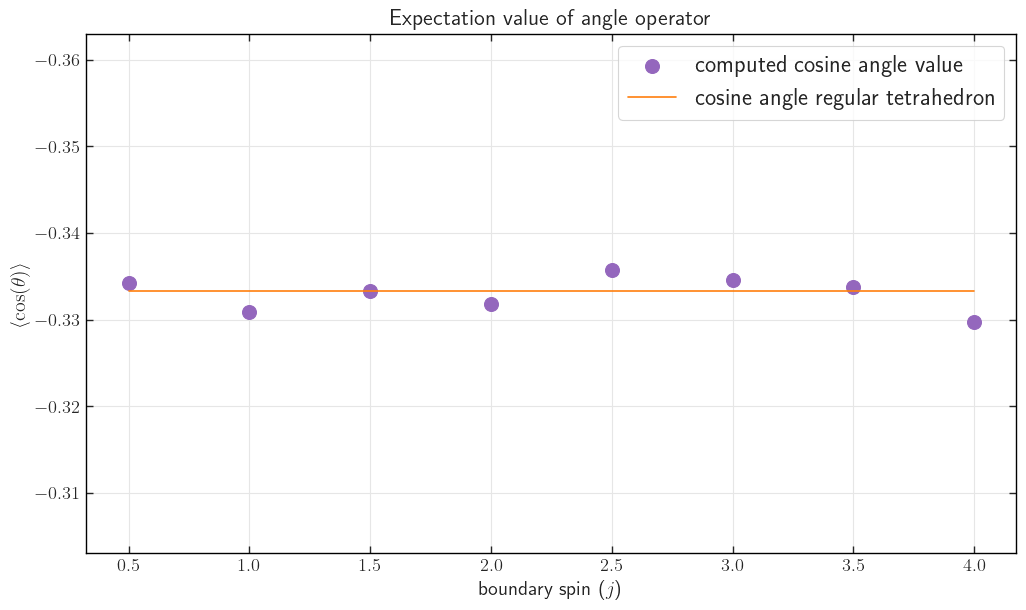

In [27]:
ax = df.plot(
    x="spin",
    y="cos_avg",
    s=100,
    kind="scatter",
    grid="false",
    color="tab:purple",
    label="computed cosine angle value",
    figsize=(12, 6.75),
)
df.plot(
    x="spin",
    y="reg_angles",
    ax=ax,
    kind="line",
    color="tab:orange",
    linewidth=1.2,
    label="cosine angle regular tetrahedron",
)
plt.legend(fontsize=14)
ax.set_ylim([-0.303, -0.363])
plt.ylabel(r"$\langle \cos (\theta) \rangle$")
plt.xlabel("boundary spin ($j$)")
plt.title("Expectation value of angle operator", fontsize=16)

plt.legend(loc="upper right", fontsize="large", fancybox=True)

# save the plot
printfile = "./plots/angles_exp_values"
plt.savefig(printfile + ".svg")
# plt.savefig(printfile+'.png',dpi=300)

plt.show()

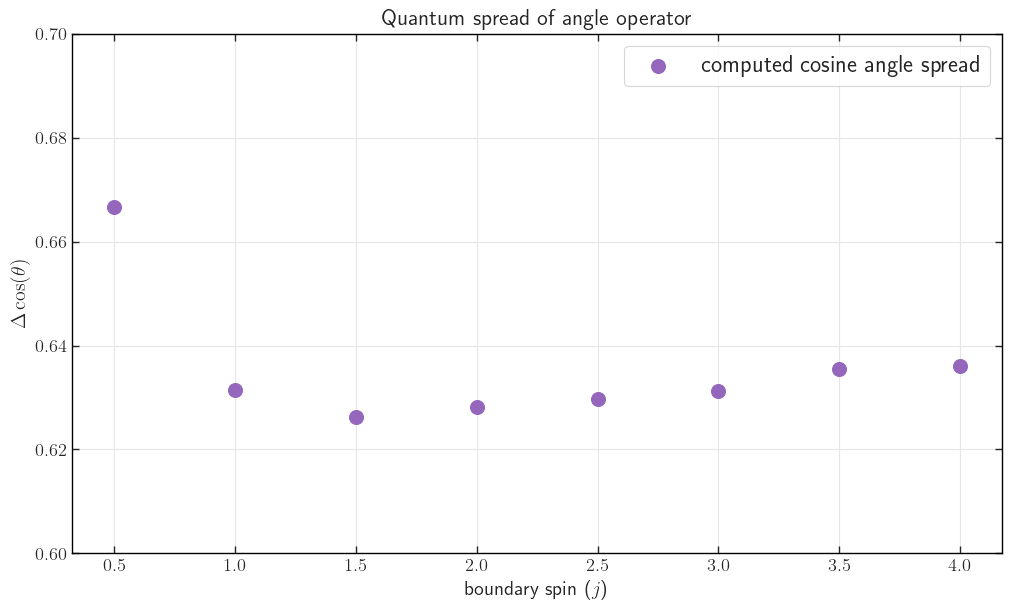

In [25]:
ax = df.plot(
    x="spin",
    y="cos_std",
    s=100,
    # xticks=corresponding_spin,
    kind="scatter",
    grid="false",
    color="tab:purple",
    label="computed cosine angle spread",
    figsize=(12, 6.75),
)

ax.set_ylim([0.6, 0.7])
plt.ylabel(r"$ \Delta \cos (\theta) $")
plt.xlabel("boundary spin ($j$)")
plt.title("Quantum spread of angle operator", fontsize=16)

plt.legend(loc="upper right", fontsize="large", fancybox=True)

# save the plot
printfile = "./plots/angles_quantum_spread"
plt.savefig(printfile + ".svg")
# plt.savefig(printfile + ".png", dpi=300)

plt.show()

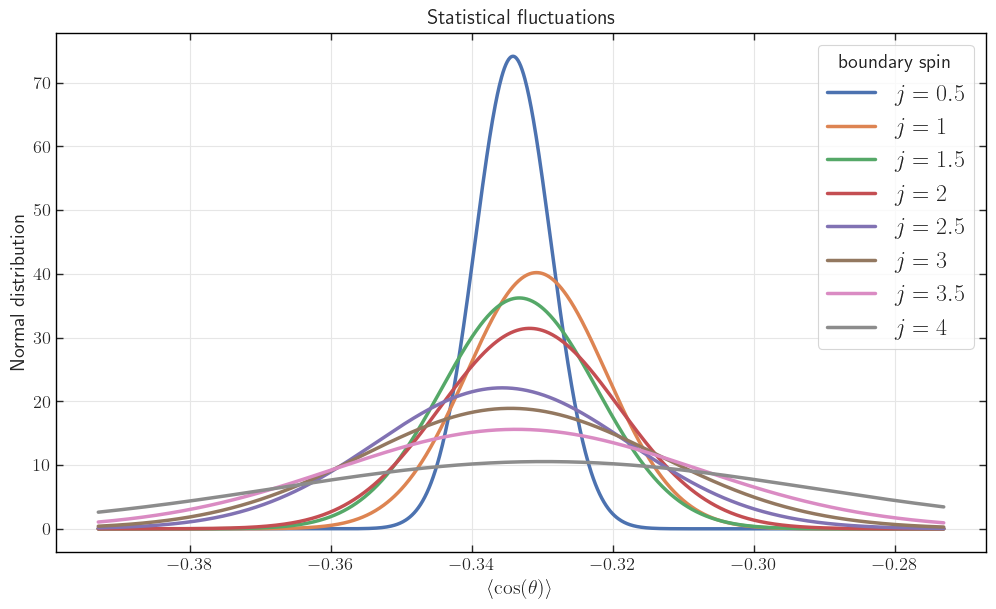

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# x-axis ranges from -5 and 5 with .001 steps
x = np.arange(-0.393, -0.273, 0.0001)

plt.figure(figsize=(12, 6.75))

# define multiple normal distributions

for spin in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:

    plt.plot(
        x,
        norm.pdf(
            x,
            df["cos_avg"][f"spin {spin}"],
            df["cos_avg_std_over_chains"][f"spin {spin}"],
        ),
        label=f"$j = {spin}$",
        linewidth=2.5,
    )

# add legend to plot
plt.legend(title="boundary spin", loc="upper right", fontsize="large", fancybox=True)

# add axes labels and a title
plt.ylabel("Normal distribution")
plt.xlabel(r"$\langle \cos (\theta) \rangle$")
plt.title("Statistical fluctuations", fontsize=15)

printfile = "./plots/angles_fluctuations"
plt.savefig(printfile + ".svg")
# plt.savefig(printfile + ".png", dpi=300)

plt.show()

In [29]:
chains_assembled = 30

node = 1

df = pd.read_csv(
    f"{data_folder}/final_tables/angles_autocorrelations_chains_assembled_{chains_assembled}_node_{node}.csv",
    low_memory=False,
    index_col=0,
)

# scatter requires a column with spins
spin_list = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
regular_cos_angles = [-0.33333 for i in range(0, 8)]

df["lag"] = df.index

# df["spin"] = spin_list
# df["reg_angles"] = regular_cos_angles

In [69]:
df

,spin 0.5,spin 1,spin 1.5,spin 2,spin 2.5,spin 3,spin 3.5,spin 4,lag
lag,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
1,0.957456,0.984998,0.991167,0.993791,0.995299,0.996335,0.997599,0.998310,1
2,0.918130,0.970613,0.982627,0.987762,0.990729,0.992759,0.995247,0.996650,2
3,0.881628,0.956777,0.974358,0.981890,0.986267,0.989263,0.992940,0.995019,3
4,0.847584,0.943433,0.966327,0.976162,0.981907,0.985842,0.990673,0.993413,4
...,...,...,...,...,...,...,...,...,...
7996,-0.001364,-0.005273,0.002553,0.004518,-0.006162,-0.001127,-0.000364,-0.005674,7996
7997,-0.001342,-0.005268,0.002540,0.004502,-0.006154,-0.001133,-0.000360,-0.005675,7997
7998,-0.001303,-0.005264,0.002527,0.004486,-0.006146,-0.001136,-0.000355,-0.005675,7998


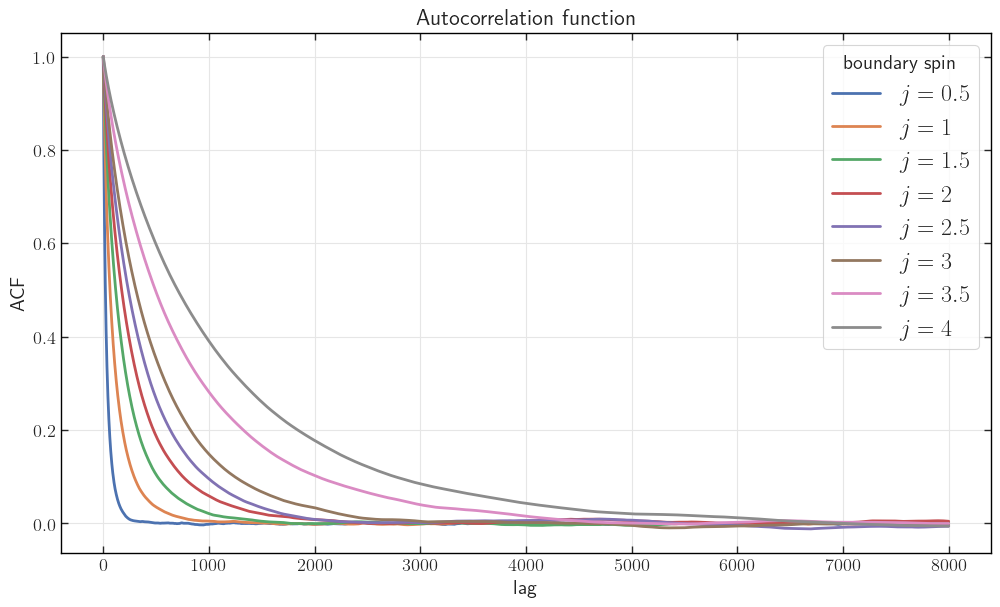

In [80]:
df.plot(
    x="lag",
    y=[
        "spin 0.5",
        "spin 1",
        "spin 1.5",
        "spin 2",
        "spin 2.5",
        "spin 3",
        "spin 3.5",
        "spin 4",
    ],
    # s=20,
    # xticks=corresponding_spin,
    kind="line",
    grid="false",
    # color="tab:purple",
    label=[
        r"$j = 0.5$",
        r"$j = 1$",
        r"$j = 1.5$",
        r"$j = 2$",
        r"$j = 2.5$",
        r"$j = 3$",
        r"$j = 3.5$",
        r"$j = 4$",
    ],
    figsize=(12, 6.75),
)

plt.legend(title="boundary spin", loc="upper right", fontsize="large", fancybox=True)

plt.ylabel("ACF")
plt.xlabel("lag")
plt.title("Autocorrelation function", fontsize=16)


# save the plot
printfile = "./plots/angles_autocorrelations"
plt.savefig(printfile + ".svg")

In [53]:
chains_assembled = 30

node = 1

# MH parameters
spin = 0.5
sigma = 0.4
length = 1000000
burnin = 10
chains = 30

df = pd.read_csv(
    f"{data_folder}/j_{spin}/N_{length}__sigma_{sigma}__burnin_{burnin}/operators/angles/correlations/chains_assembled_{chains}.csv",
    low_memory=False,
    index_col=0,
)

df = df.round(decimals=3)

In [54]:
df

,node 1,node 2,node 3,node 4,node 5,node 6,node 7,node 8,node 9,node 10,node 11,node 12,node 13,node 14,node 15,node 16
node 1,1.000,-0.083,-0.055,0.162,0.005,-0.008,0.048,0.159,0.107,-0.010,-0.017,0.015,0.004,-0.007,-0.056,0.162
node 2,-0.083,1.000,-0.080,-0.054,-0.008,-0.055,0.161,0.050,-0.008,0.005,-0.007,-0.017,-0.008,-0.053,0.161,-0.055
node 3,-0.055,-0.080,1.000,-0.081,-0.054,0.161,-0.054,-0.009,-0.017,-0.007,0.003,-0.008,0.050,0.158,-0.054,-0.008
node 4,0.162,-0.054,-0.081,1.000,0.161,-0.055,-0.009,0.005,0.017,-0.016,-0.007,0.108,0.159,0.050,-0.007,0.006
node 5,0.005,-0.008,-0.054,0.161,1.000,-0.079,-0.056,0.161,0.005,-0.009,0.051,0.160,0.107,-0.006,-0.017,0.015
node 6,-0.008,-0.055,0.161,-0.055,-0.079,1.000,-0.082,-0.054,-0.006,-0.055,0.160,0.051,-0.006,0.004,-0.009,-0.016
node 7,0.048,0.161,-0.054,-0.009,-0.056,-0.082,1.000,-0.079,-0.055,0.161,-0.055,-0.008,-0.016,-0.009,0.006,-0.009
node 8,0.159,0.050,-0.009,0.005,0.161,-0.054,-0.079,1.000,0.161,-0.055,-0.007,0.004,0.015,-0.015,-0.006,0.108
node 9,0.107,-0.008,-0.017,0.017,0.005,-0.006,-0.055,0.161,1.000,-0.081,-0.053,0.161,0.006,-0.008,0.048,0.160
node 10,-0.010,0.005,-0.007,-0.016,-0.009,-0.055,0.161,-0.055,-0.081,1.000,-0.078,-0.055,-0.009,-0.054,0.161,0.049


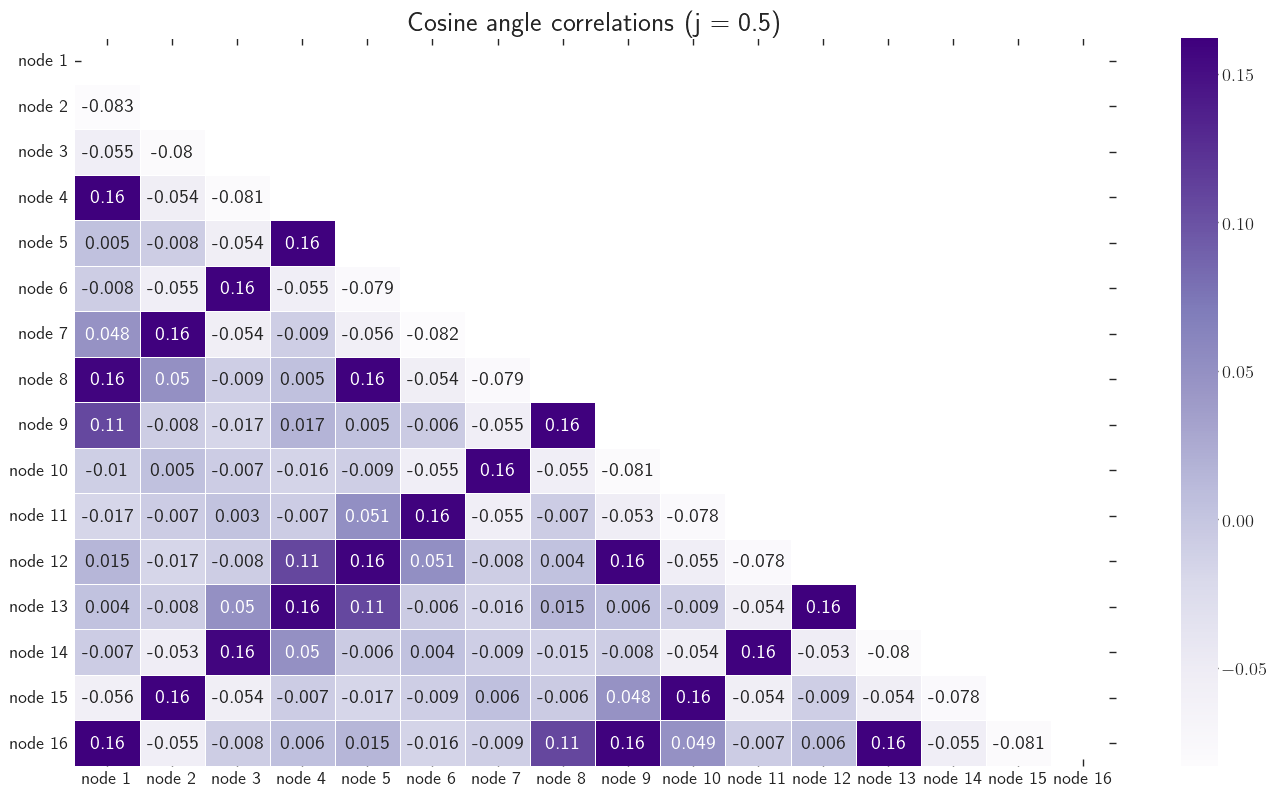

In [55]:
scale = 1.4

mask = np.triu(np.ones_like(df, dtype=bool))

# df.style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)
plt.figure(figsize=(12 * scale, 6.75 * scale))
# plt.figure(figsize=(11, 8))
ax = plt.axes()
sns.heatmap(df, annot=True, mask=mask, linewidth=0.5, cmap="Purples", ax=ax)

ax.set_title(f"Cosine angle correlations (j = {spin})", fontsize=20)

# save the plot
printfile = f"./plots/angles_correlations_spin_{spin}"
plt.savefig(printfile + ".svg")

# Size hash tables 

In [40]:
size_hash_tables_in_MB = [
    12.8e-03,
    409.5e-03,
    6.55,
    52.42,
    209.71,
    838.86,
    3.35e03,
    6.71e03,
]
corresponding_spin = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

# fit log(size) = m*log(j) + c
m, c = np.polyfit(
    np.log(corresponding_spin),
    np.log(size_hash_tables_in_MB),
    1,
    w=np.sqrt(size_hash_tables_in_MB),
)
size_fit = np.exp(m * np.log(corresponding_spin) + c)

df = pd.DataFrame(
    {
        "spin": corresponding_spin,
        "table_size": size_hash_tables_in_MB,
        "fitted_data": size_fit,
    }
)

In [41]:
from matplotlib.ticker import ScalarFormatter

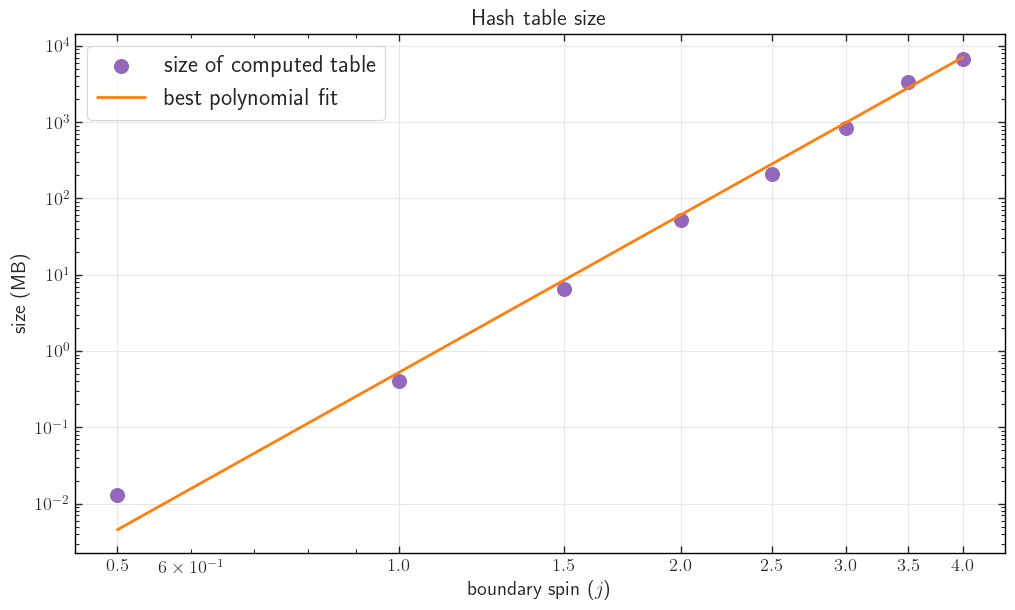

In [43]:
ax = df.plot(
    x="spin",
    y="table_size",
    s=100,
    xticks=corresponding_spin,
    kind="scatter",
    grid="false",
    color="tab:purple",
    label="size of computed table",
    logy=True,
    logx=True,
    figsize=(12, 6.75),
)
df.plot(
    x="spin",
    y="fitted_data",
    ax=ax,
    kind="line",
    color="tab:orange",
    label="best polynomial fit",
)

plt.legend(loc="upper left", fontsize="large", fancybox=True)

plt.ylabel("size (MB)")
plt.xlabel("boundary spin ($j$)")
plt.title("Hash table size", fontsize=16)
ax.xaxis.set_major_formatter(ScalarFormatter())

printfile = "./plots/hash_table_size"
plt.savefig(printfile + ".svg")

plt.show()